In [11]:
# Import necessary libraries
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

In [12]:
# Define a transformation to convert images to tensors
transform = torchvision.transforms.ToTensor()

# Load and preprocess the CIFAR10 training dataset
training_data = torchvision.datasets.CIFAR10(
    root="data",  # Directory to store the data
    train=True,   # Load training data
    download=True,  # Download the dataset if not already present
    transform=transform  # Apply the transformation
)

# Load and preprocess the CIFAR10 testing dataset
validation_data = torchvision.datasets.CIFAR10(
    root="data",  # Directory to store the data
    train=False,  # Load validation/test data
    download=True,  # Download the dataset if not already present
    transform=transform  # Apply the transformation
)

Files already downloaded and verified
Files already downloaded and verified


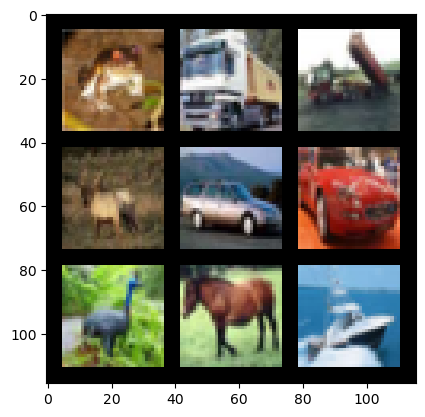

In [13]:
# Display a grid of 9 sample images from the training dataset
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [14]:
# Select the device for training (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract data and targets from the datasets and convert them to tensors
X_train = torch.tensor(training_data.data)  # Training images
Y_train = torch.tensor(training_data.targets)  # Training labels
X_test = torch.tensor(validation_data.data)  # Testing images
Y_test = torch.tensor(validation_data.targets)  # Testing labels

# Convert image data from (batch, height, width, channels) to (batch, channels, height, width)
# and normalize pixel values to range [0, 1]
X_train = X_train.permute(0, 3, 1, 2).float() / 255.0
X_test = X_test.permute(0, 3, 1, 2).float() / 255.0

# Create TensorDataset and DataLoader for training and testing
dataset_train = TensorDataset(X_train, Y_train)
dataloader_train = DataLoader(dataset_train, batch_size=10, shuffle=True)  # Shuffle for random sampling

dataset_test = TensorDataset(X_test, Y_test)
dataloader_test = DataLoader(dataset_test, batch_size=10, shuffle=False)  # No shuffle for testing

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, in_chan, num_classes):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=in_chan, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization for the first layer
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization for the second layer
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization for the third layer
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # Flattened size * number of neurons
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for classification
        self.drop = nn.Dropout(0.7)  # Dropout layer for regularization
        self.relu = nn.ReLU()  # Activation function
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer

    def forward(self, x):
        # Forward pass through the CNN
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # Conv1 -> ReLU -> Pooling
        x = self.pool(self.relu(self.bn2(self.conv2(x))))  # Conv2 -> ReLU -> Pooling
        x = self.pool(self.relu(self.bn3(self.conv3(x))))  # Conv3 -> ReLU -> Pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor for the fully connected layer
        x = self.relu(self.fc1(x))  # Fully connected layer 1
        x = self.drop(x)  # Apply dropout
        x = self.fc2(x)  # Fully connected layer 2
        return x

In [15]:
# Set hyperparameters
epochs = 20
learning_rate = 0.001
num_classes = 10

# Initialize the model, optimizer, and loss function
model = CNN(3, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Use Adam optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
model.train()  # Set the model to training mode

# Training loop
for epoch in range(epochs):
    training_losses = []
    for batch in dataloader_train:
        x, y = batch[0].to(device), batch[1].to(device)  # Move data to device
        optimizer.zero_grad()  # Zero the gradients
        pred = model(x)  # Forward pass
        loss = criterion(pred, y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        training_losses.append(loss.item())  # Record training loss
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))

Finished Epoch 1 , training loss: 1.8742314101696014
Finished Epoch 2 , training loss: 1.695737708044052
Finished Epoch 3 , training loss: 1.57674075050354
Finished Epoch 4 , training loss: 1.4854786555409432
Finished Epoch 5 , training loss: 1.3564568949699403
Finished Epoch 6 , training loss: 1.257598449832201
Finished Epoch 7 , training loss: 1.1663344010472299
Finished Epoch 8 , training loss: 1.1144772855132818
Finished Epoch 9 , training loss: 1.0705056470692158
Finished Epoch 10 , training loss: 1.0381461083292962
Finished Epoch 11 , training loss: 1.0150742425262929
Finished Epoch 12 , training loss: 0.9834517185151577
Finished Epoch 13 , training loss: 0.9621627259105444
Finished Epoch 14 , training loss: 0.9359953616648913
Finished Epoch 15 , training loss: 0.9233004413098097
Finished Epoch 16 , training loss: 0.8995092823550105
Finished Epoch 17 , training loss: 0.883456897944212
Finished Epoch 18 , training loss: 0.8709494135797023
Finished Epoch 19 , training loss: 0.85634

In [ ]:
# Evaluate the model on the training set
with torch.no_grad():  # Disable gradient computation for evaluation
    model.eval()  # Set the model to evaluation mode
    num_correct = 0
    total_size = 0
    for batch in dataloader_train:
        x, y = batch[0].to(device), batch[1].to(device)
        pred = model(x)  # Forward pass
        pred_labels = torch.argmax(pred, dim=1)  # Get predicted labels
        num_correct += (y == pred_labels).sum().item()  # Count correct predictions
        total_size += y.shape[0]  # Total samples
    print("Final Accuracy on Training Data:", num_correct / total_size)
    model.train()  # Return to training mode

# Evaluate the model on the testing set
with torch.no_grad():  # Disable gradient computation for evaluation
    model.eval()  # Set the model to evaluation mode
    num_correct = 0
    total_size = 0
    for batch in dataloader_test:
        x, y = batch[0].to(device), batch[1].to(device)
        pred = model(x)  # Forward pass
        pred_labels = torch.argmax(pred, dim=1)  # Get predicted labels
        num_correct += (y == pred_labels).sum().item()  # Count correct predictions
        total_size += y.shape[0]  # Total samples
    print("Final Accuracy on Testing Data:", num_correct / total_size)
    model.train()  # Return to training mode